# QuantumSim - Grover Search using Counter
Author: Nico Kuijpers<br>
Date: January 2, 2025

In this notebook we use Grover's algorithm to search for binary strings of length $n$ having exactly $k$ ones ($0 \leq k \leq n$). 
Within the Grover oracle, the number of ones is counted using a counter as introduced in this notebook from QuantumSim:

https://github.com/nicokuijpers/QuantumSim/blob/main/QuantumSimCounter.ipynb

For an implementation of Grover's algorithm in QuantumSim, we refer to this notebook:

https://github.com/nicokuijpers/QuantumSim/blob/main/QuantumSimGroverAlgorithm.ipynb

In [1]:
from quantumsim import *

## Introduction
Suppose we want to find all possible binary strings of length $n$ with exactly $k$ ones and $n-k$ zeros. 
The number of possible strings is then $2^N$ and the number of strings with exactly $k$ ones is equal to

$\binom{n}{k} = \frac{n!}{k! (n-k)!}$.

For example, for $n=5$ and $k=2$, the number of possible strings is $2^5 = 32$ and the number of strings
with exactly $k$ ones is

$\binom{n}{k} = \frac{n!}{k! (n-k)!} = \frac{5!}{2! \cdot 3!} = \frac{120}{2 \cdot 6} = \frac{120}{12} = 10$.

These $10$ strings are:
$00011$, $00101$, $00110$, $01001$, $01010$, $01100$, $10001$, $10010$, $10100$, $11000$. 

These strings can be found using Grover's algorithm. Using a counter of $1$, $2$ or $3$ qubits, a
Grover oracle can be constructed to find strings of length $n$ with exactly $k$ ones, for $0 < n < 7$ and $0 \leq k \leq n$.

The Grover oracle is constructed as follows:
1. Determine the number of qubits $m$ needed for the counter.
2. Determine which of the $m$ counter qubits should be zero. 
3. Construct a counter of $m$ qubits as described above.
4. Apply Pauli X operations on the counter qubits that should be zero.
5. Apply a multi-controlled Pauli Z operation on all counter qubits.
6. Apply Pauli X operations on the counter qubits that should be zero.
7. Construct a reversed version of the counter.

Note that step 7 is necessary such that the Grover oracle can be used multiple times.

In [2]:
def create_grover_oracle(nr_zeros:int, nr_ones:int) -> Circuit:

    # Determine the length of the binary strings, n
    n = nr_zeros + nr_ones
    if n < 1 or n > 7:
        raise ValueError("Sum of nr_zeros and nr_ones must be at least 1 and at most 7")
    
    # Determine the number of counter qubits, m
    binary_string = bin(n)[2:]
    m = len(binary_string)
    
    # Determine the counter qubits that should be zero
    nr_ones_binary = bin(nr_ones)[2:].zfill(m)
    zero_inds = [ind for ind in range(m) if nr_ones_binary.startswith("0",ind)]

    # Construct a circuit of size n + m
    circuit = Circuit(n + m)

    # Counter for m = 1
    if m == 1:
        circuit.cnot(0,1)

    # Counter for m = 2
    if m == 2:
        for q in range(n):
            circuit.toffoli(q, n + 1, n)
            circuit.cnot(q, n + 1)

    # Counter for m = 3
    if m == 3:
        for q in range(n):
            circuit.generic_toffoli([q, n + 2, n + 1], n)
            circuit.toffoli(q, n + 2, n + 1)
            circuit.cnot(q, n + 2)

    # Construct a circuit to apply a multi-controlled Pauli Z operation on the counter qubits
    # Apply Pauli X operations on counter qubits that should be zero 
    # Apply a multi-controlled Pauli Z operation on the counter qubits
    # Apply Pauli X operations on counter qubits that should be zero
    # Append this circuit to the grover oracle starting from qubit n 
    circuit_extra = Circuit(m)
    for i in zero_inds:
        circuit_extra.pauli_x(i)
    circuit_extra.multi_controlled_pauli_z()
    for i in zero_inds:
        circuit_extra.pauli_x(i)
    circuit.append_circuit_general(circuit_extra, n)

    # Reverse counter for m = 1
    if m == 1:
        circuit.cnot(0,1)

    # Reverse counter for m = 2
    if m == 2:
        for q in range(n-1, -1, -1):
            circuit.cnot(q, n + 1)
            circuit.toffoli(q, n + 1, n)
            
    # Reverse counter for m = 3
    if m == 3:
        for q in range(n-1, -1, -1):
            circuit.cnot(q, n + 2)
            circuit.toffoli(q, n + 2, n + 1)
            circuit.generic_toffoli([q, n + 2, n + 1], n)

    return circuit


Below, a function is defined to create the Grover operator using a Grover oracle.

In [3]:
def create_grover_operator(oracle:Circuit) -> Circuit:
    grover = Circuit(oracle.N)
    grover.append_circuit(oracle)
    for q in range (grover.N):
        grover.hadamard(q)
    for q in range (grover.N):
        grover.pauli_x(q)
    grover.hadamard(grover.N - 1)
    grover.multi_controlled_pauli_x() 
    grover.hadamard(grover.N - 1)
    for q in range (grover.N):
        grover.pauli_x(q)
    for q in range (grover.N):
        grover.hadamard(q)
    return grover

Below, a function is defined to create the Grover circuit. This function has as input parameters *nr_zeros*, *nr_ones*, and *nr_iterations*.
The latter determines how many times the Grover operator is repeated in the Grover circuit. 
Using Hadamrd gates, the input qubits are brought into superposition. The counter qubits have initial state $|0\rangle$.

In [4]:
def create_grover_circuit(nr_zeros:int, nr_ones:int, nr_iterations:int) -> Circuit:
    
    # Determine the length of the binary strings, n
    n = nr_zeros + nr_ones
    if n < 1 or n > 7:
        raise ValueError("Sum of nr_zeros and nr_ones must be at least 1 and at most 7")
    
    # Create the Grover oracle
    oracle = create_grover_oracle(nr_zeros, nr_ones)

    # Create the Grover operator
    grover_operator = create_grover_operator(oracle)

    # Create the Grover circuit
    circuit = Circuit(oracle.N)

    # Apply Hadamard gates on the input qubits, but not on the counter qubits
    for q in range(n):
        circuit.hadamard(q)
    
    # Repeat the Grover operator
    for i in range(nr_iterations):
        circuit.append_circuit(grover_operator)

    return circuit

## Example
In the example below, Grover's search algorithm is applied to find all binary strings of length 3 with exactly 2 ones.

The optimal number of iterations $k_{\text{opt}}$ is defined by

$k_{\text{opt}} = \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor$, where

$N$ is the number of possible strings and $M$ the number of accepted solutions.

In this case $N=2^3=8$ and 

$M=\binom{3}{2} = \frac{3!}{2! \cdot 1!} = \frac{6}{2 \cdot 1} = 3$, 

thus the optimal number of solutions is

$k_{\text{opt}} = \left\lfloor \frac{\pi}{4} \sqrt{\frac{8}{3}} \right\rfloor = 1$

In [5]:
# Determine number of possible strings and possible solutions
nr_zeros = 1
nr_ones = 2
nr_possible_solutions = 2**(nr_zeros + nr_ones)
nr_accepted_solutions = math.comb(nr_zeros + nr_ones, nr_ones)

# Determine optimal number of iterations 
nr_iterations = max(1, math.floor((math.pi / 4) * math.sqrt((nr_possible_solutions/nr_accepted_solutions))))

# Print 
print(f"Number of zeros  : {nr_zeros}")
print(f"Number of ones   : {nr_ones}")
print(f"Number of possible solutions : {nr_possible_solutions}")
print(f"Number of accepted solutions : {nr_accepted_solutions}")
print(f"Optimal number of iterations : {nr_iterations}")

# Create the Grover circuit
circuit = create_grover_circuit(nr_zeros, nr_ones, nr_iterations)

Number of zeros  : 1
Number of ones   : 2
Number of possible solutions : 8
Number of accepted solutions : 3
Optimal number of iterations : 1


Below, the circuit is executed and 20000 measurements are performed.

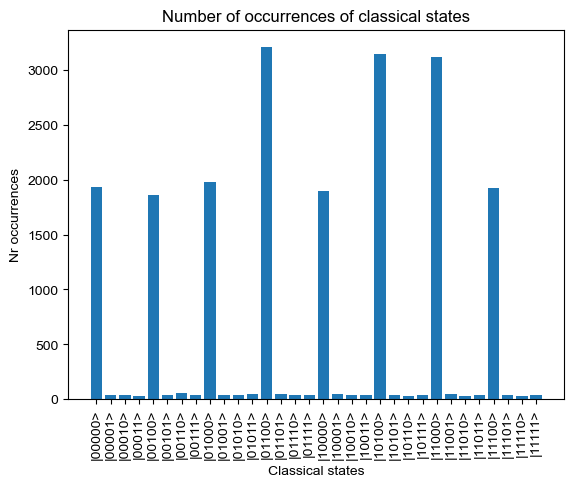

In [6]:
result = QuantumUtil.measure_circuit(circuit, nr_measurements=20000)
QuantumUtil.histogram_of_classical_states(result)

Accepted solutions should end with exactly $m$ zeros, where $m$ is the number of counter qubits. Below, all results not ending with $m$ zeros are removed.

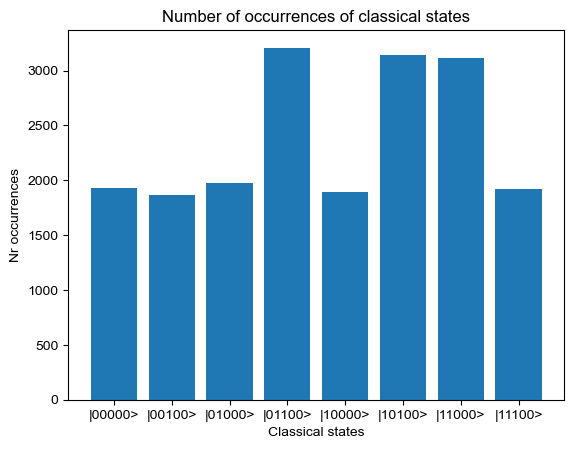

In [7]:
# Determine the number of counting qubits
n = nr_zeros + nr_ones
binary_string = bin(n)[2:]
m = len(binary_string)

# Retain results ending with m zeros.
results_ending_with_zeros = [s for s in result if s.endswith("0"*m + ">")]
QuantumUtil.histogram_of_classical_states(results_ending_with_zeros)

It can be observed that results $|01100\rangle$, $|10100\rangle$, and $|11000\rangle$ occur the most. Indeed, these results represent the $3$ accepted solutions.

## Testing
Below, a function is defined to create a Grover circuit, execute it, and measure the results. 
From the resulting measurements, two sets are created. 
If $M$ represents the number of accepted solutions, then one set contains the $M$ most common 
occurrences of result strings and the other set contains all other result strings.

If $m$ is the number of counting qubits, all result strings in the most common set should end with $m$ 
zeros and have exactly the desired number of ones.
All other result strings should either not end with $m$ zeros or have a different number of ones.

A histogram of results ending with zeros is plotted if parameter *plot_histogram* is True.
Any violations are printed and the total number of violations per set is counted.

Finally, the list of accepted solutions found by Grover's algorithm is printed. 
Note that this list is NOT corrected for any violations found during the test.

In [8]:
def test_grover_circuit(nr_zeros:int, nr_ones:int, nr_measurements:int, plot_histogram:bool=False, nr_iterations:int=None):

    # Determine number of possible solutions and accepted solutions
    nr_possible_solutions = 2**(nr_zeros + nr_ones)
    nr_accepted_solutions = math.comb(nr_zeros + nr_ones, nr_ones)

    if nr_iterations == None:
        # Determine optimal number of iterations
        nr_iterations = max(1, math.floor((math.pi / 4) * math.sqrt((nr_possible_solutions/nr_accepted_solutions))))

        #To avoid a large number of iterations 
        if (nr_zeros + nr_ones >= 6) and (nr_zeros == 0 or nr_ones == 0):
            nr_iterations = 1

    # Print 
    print(f"Number of zeros  : {nr_zeros}")
    print(f"Number of ones   : {nr_ones}")
    print(f"Number of possible solutions : {nr_possible_solutions}")
    print(f"Number of accepted solutions : {nr_accepted_solutions}")
    print(f"Optimal number of iterations : {nr_iterations}")
    
    # Create a Grover circuit
    circuit = create_grover_circuit(nr_zeros, nr_ones, nr_iterations)

    # Execute the Grover circuit and measure multiple times
    result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)

    # Plot a histogram of all results
    if plot_histogram:
        QuantumUtil.histogram_of_classical_states(result)

    # Count occurrences of each string in result
    counter = Counter(result)

    # Get the nr_accepted_solutions most common strings as a list of tuples (string, count)
    most_common_strings = counter.most_common(nr_accepted_solutions)

    # Get nr_accepted_solutions most common strings only
    most_common_strings_only = [item[0] for item in most_common_strings]

    # Convert most_common_strings_only to a set for faster lookups
    most_common_set = set(most_common_strings_only)

    # Get strings that are not in most_common_strings_only
    not_in_common = [s for s in result if s not in most_common_set]
    not_in_common_set = set(not_in_common)

    # Determine the number of bits for counting
    binary_string = bin(nr_zeros + nr_ones)[2:]
    nr_count_bits = len(binary_string)

    # All strings in most_common_strings should have exactly nr_ones ones
    # These strings should all end with nr_count_bits zeros
    nr_violations_common = 0
    for s in most_common_strings_only:
        if not s.endswith("0"*nr_count_bits + ">"):
            print(f"\tresult = {s} and and counter is not zero")
            nr_violations_common += 1
        else:
            nr_ones_in_string = s.count('1')
            if nr_ones_in_string != nr_ones:
                print(f"\tresult = {s} and number of ones is {nr_ones_in_string}")
                nr_violations_common += 1
    print(f"Number of violations in set of most common strings is {nr_violations_common}")

    # All other strings should have a different number of ones, but only
    # if they end with nr_count_bits zeros
    nr_violations_not_in_common = 0
    for s in not_in_common_set:
        substring_count = s[-(nr_count_bits+1):-1]
        nr_ones_in_substring_count = substring_count.count('1')
        if nr_ones_in_substring_count == 0:
            substring = s[1:len(s)-nr_count_bits-1]
            nr_ones_in_string = substring.count('1')
            if nr_ones_in_string == nr_ones:
                print(f"\tresult = {s} and number of ones is {nr_ones_in_string}")
                nr_violations_not_in_common += 1
    print(f"Number of violations in set of other strings is {nr_violations_not_in_common}")

    # Print the accepted solutions
    accepted_solutions = [s[1:len(s)-nr_count_bits-1] for s in most_common_set]
    print("Accepted solutions (not corrected for violations):")
    print(sorted(accepted_solutions))

Below, a Grover circuit is tested for $1$ zero and $2$ ones.

Number of zeros  : 1
Number of ones   : 2
Number of possible solutions : 8
Number of accepted solutions : 3
Optimal number of iterations : 1


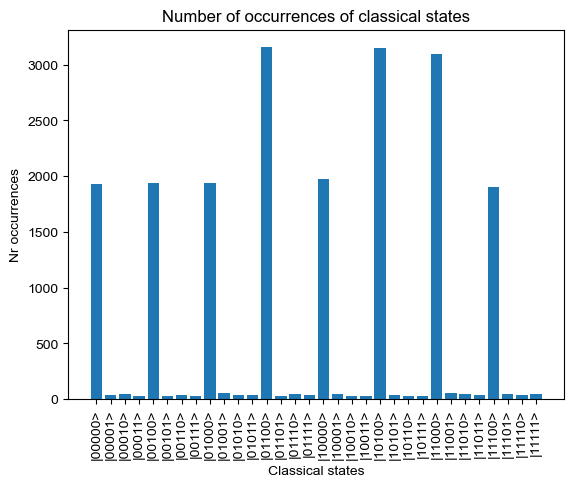

Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['011', '101', '110']


In [9]:
test_grover_circuit(nr_zeros=1, nr_ones=2, nr_measurements=20000, plot_histogram=True)

Next, a Grover circuit is tested for $1$ zero and $0$ ones.

Number of zeros  : 1
Number of ones   : 0
Number of possible solutions : 2
Number of accepted solutions : 1
Optimal number of iterations : 1


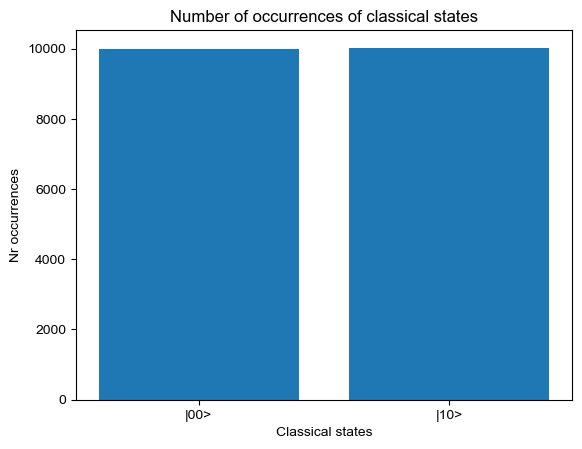

	result = |10> and number of ones is 1
Number of violations in set of most common strings is 1
	result = |00> and number of ones is 0
Number of violations in set of other strings is 1
Accepted solutions (not corrected for violations):
['1']


In [10]:
test_grover_circuit(nr_zeros=1, nr_ones=0, nr_measurements=20000, plot_histogram=True)

If you run the code block multiple times, you will find that sometimes a violation is detected. From the histogram it can be concluded that the number of occurrrences of $|00\rangle$ and $|10\rangle$ are about equal. Hence, this Grover circuit is not suitable to generate the strings "0" or "1".

Below, a Grover circuit is tested for $1$ zero and $1$ one.

Number of zeros  : 1
Number of ones   : 1
Number of possible solutions : 4
Number of accepted solutions : 2
Optimal number of iterations : 1


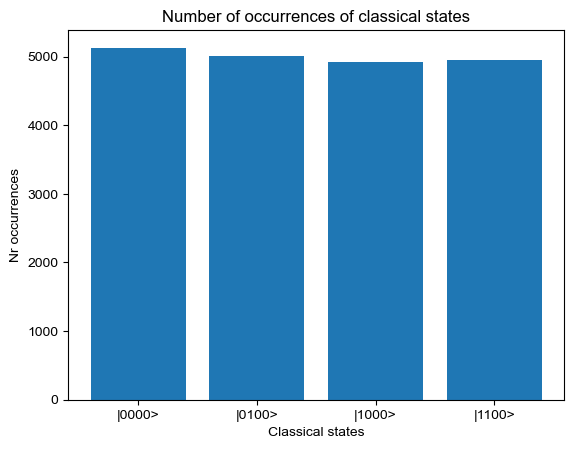

	result = |0000> and number of ones is 0
Number of violations in set of most common strings is 1
	result = |1000> and number of ones is 1
Number of violations in set of other strings is 1
Accepted solutions (not corrected for violations):
['00', '01']


In [11]:
test_grover_circuit(nr_zeros=1, nr_ones=1, nr_measurements=20000, plot_histogram=True)

If you run the code block multiple times, you will find that sometimes violations are detected. From the histogram it can be concluded that the number of occurrrences of $|0000\rangle$, $|0100\rangle$, $|1000\rangle$, and $|1100\rangle$ are all about equal. Hence, also this Grover circuit is not suitable to generate binary strings of length $2$ with exactly $0$, $1$ or $2$ ones.

Below, a Grover circuit is tested for $0$ zeros and $2$ ones.

Number of zeros  : 0
Number of ones   : 2
Number of possible solutions : 4
Number of accepted solutions : 1
Optimal number of iterations : 1


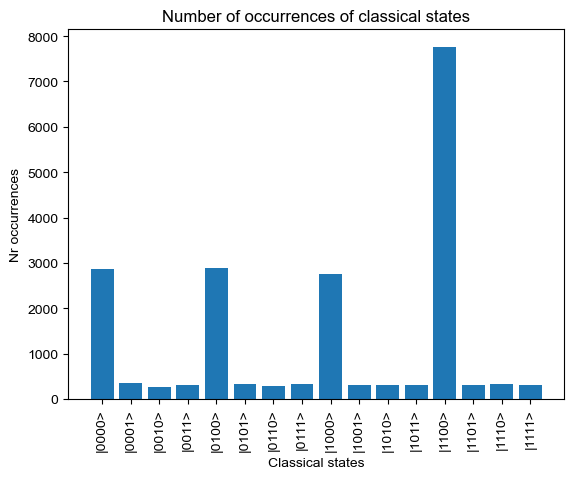

Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['11']


In [12]:
test_grover_circuit(nr_zeros=0, nr_ones=2, nr_measurements=20000, plot_histogram=True)

Below, a function is defined to test all possible Grover circuits for a given number of bits. Using this function, all possible Grover circuits for binary strings up to length 5 are tested. Testing circuits for longer strings take more computational time and memory. To test these circuits, you should uncomment the code in cells [19] and [20].

In [13]:
def test_all_grover_circuits(nr_bits:int, nr_measurements:int):
    for nr_ones in range(nr_bits+1):
        nr_zeros = nr_bits - nr_ones
        test_grover_circuit(nr_zeros=nr_zeros, nr_ones=nr_ones, nr_measurements=nr_measurements)

In [14]:
test_all_grover_circuits(nr_bits=1, nr_measurements=20000)

Number of zeros  : 1
Number of ones   : 0
Number of possible solutions : 2
Number of accepted solutions : 1
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0']
Number of zeros  : 0
Number of ones   : 1
Number of possible solutions : 2
Number of accepted solutions : 1
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['1']


In [15]:
test_all_grover_circuits(nr_bits=2, nr_measurements=20000)

Number of zeros  : 2
Number of ones   : 0
Number of possible solutions : 4
Number of accepted solutions : 1
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['00']
Number of zeros  : 1
Number of ones   : 1
Number of possible solutions : 4
Number of accepted solutions : 2
Optimal number of iterations : 1
	result = |1100> and number of ones is 2
Number of violations in set of most common strings is 1
	result = |0100> and number of ones is 1
Number of violations in set of other strings is 1
Accepted solutions (not corrected for violations):
['10', '11']
Number of zeros  : 0
Number of ones   : 2
Number of possible solutions : 4
Number of accepted solutions : 1
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['11

In [16]:
test_all_grover_circuits(nr_bits=3, nr_measurements=20000)

Number of zeros  : 3
Number of ones   : 0
Number of possible solutions : 8
Number of accepted solutions : 1
Optimal number of iterations : 2
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['000']
Number of zeros  : 2
Number of ones   : 1
Number of possible solutions : 8
Number of accepted solutions : 3
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['001', '010', '100']
Number of zeros  : 1
Number of ones   : 2
Number of possible solutions : 8
Number of accepted solutions : 3
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['011', '101', '110']
Number of zeros  : 0
Number of ones   : 3
Number of po

In [17]:
test_all_grover_circuits(nr_bits=4, nr_measurements=20000)

Number of zeros  : 4
Number of ones   : 0
Number of possible solutions : 16
Number of accepted solutions : 1
Optimal number of iterations : 3
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0000']
Number of zeros  : 3
Number of ones   : 1
Number of possible solutions : 16
Number of accepted solutions : 4
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0001', '0010', '0100', '1000']
Number of zeros  : 2
Number of ones   : 2
Number of possible solutions : 16
Number of accepted solutions : 6
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0011', '0101', '0110', '1001', '1010', '1100']
Number of ze

In [18]:
test_all_grover_circuits(nr_bits=5, nr_measurements=20000)

Number of zeros  : 5
Number of ones   : 0
Number of possible solutions : 32
Number of accepted solutions : 1
Optimal number of iterations : 4
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['00000']
Number of zeros  : 4
Number of ones   : 1
Number of possible solutions : 32
Number of accepted solutions : 5
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['00001', '00010', '00100', '01000', '10000']
Number of zeros  : 3
Number of ones   : 2
Number of possible solutions : 32
Number of accepted solutions : 10
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['00011', '00101', '00110', '01001', '01010', 

In [ ]:
#test_all_grover_circuits(nr_bits=6, nr_measurements=20000)

Number of zeros  : 6
Number of ones   : 0
Number of possible solutions : 64
Number of accepted solutions : 1
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['000000']
Number of zeros  : 5
Number of ones   : 1
Number of possible solutions : 64
Number of accepted solutions : 6
Optimal number of iterations : 2
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['000001', '000010', '000100', '001000', '010000', '100000']
Number of zeros  : 4
Number of ones   : 2
Number of possible solutions : 64
Number of accepted solutions : 15
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['000011', '000101', '000110',

In [ ]:
#test_all_grover_circuits(nr_bits=7, nr_measurements=20000)

Number of zeros  : 7
Number of ones   : 0
Number of possible solutions : 128
Number of accepted solutions : 1
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0000000']
Number of zeros  : 6
Number of ones   : 1
Number of possible solutions : 128
Number of accepted solutions : 7
Optimal number of iterations : 3
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0000001', '0000010', '0000100', '0001000', '0010000', '0100000', '1000000']
Number of zeros  : 5
Number of ones   : 2
Number of possible solutions : 128
Number of accepted solutions : 21
Optimal number of iterations : 1
Number of violations in set of most common strings is 0
Number of violations in set of other strings is 0
Accepted solutions (not corrected for violations):
['0000011

In function *test_grover_circuit()* the optimal number of iterations is determined based on the number of possible solutions $N$ and the number of accepted solutions $M$. 
For binary string length $6$, $N=2^6=64$ and for string length $7$, $N=2^7=128$.
In case the number of zeros or the number of ones is equal to $0$, there is only one accepted solution, hence $M=1$.

In that case, the optimal number of iterations for string length $6$ is 

$k_{\text{opt}} = \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor = \left\lfloor \frac{\pi}{4} \sqrt{\frac{64}{1}} \right\rfloor = 6$.

In [21]:
nr_zeros = 0
nr_ones = 6
nr_possible_solutions = 2**(nr_zeros + nr_ones)
nr_accepted_solutions = math.comb(nr_zeros + nr_ones, nr_ones)
nr_iterations = max(1, math.floor((math.pi / 4) * math.sqrt((nr_possible_solutions/nr_accepted_solutions))))
print(f"Number of zeros  : {nr_zeros}")
print(f"Number of ones   : {nr_ones}")
print(f"Number of possible solutions : {nr_possible_solutions}")
print(f"Number of accepted solutions : {nr_accepted_solutions}")
print(f"Optimal number of iterations : {nr_iterations}")

Number of zeros  : 0
Number of ones   : 6
Number of possible solutions : 64
Number of accepted solutions : 1
Optimal number of iterations : 6


The optimal number of iterations for string length $7$ is

$k_{\text{opt}} = \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor = \left\lfloor \frac{\pi}{4} \sqrt{\frac{128}{1}} \right\rfloor = 8$.

In [22]:
nr_zeros = 0
nr_ones = 7
nr_possible_solutions = 2**(nr_zeros + nr_ones)
nr_accepted_solutions = math.comb(nr_zeros + nr_ones, nr_ones)
nr_iterations = max(1, math.floor((math.pi / 4) * math.sqrt((nr_possible_solutions/nr_accepted_solutions))))
print(f"Number of zeros  : {nr_zeros}")
print(f"Number of ones   : {nr_ones}")
print(f"Number of possible solutions : {nr_possible_solutions}")
print(f"Number of accepted solutions : {nr_accepted_solutions}")
print(f"Optimal number of iterations : {nr_iterations}")

Number of zeros  : 0
Number of ones   : 7
Number of possible solutions : 128
Number of accepted solutions : 1
Optimal number of iterations : 8


In function *test_grover_circuit()* the number of interations is set to $1$ in these cases. 
This can be overruled by passing parameter *nr_iterations* with the number of iterations of your own choice.

Below, a Grover circuit is tested with $0$ zeros and $6$ ones. The number of iterations is set to $6$. Note that the result is actually wrong. 
You can try any number of iterations, but you will find that only $1$ iteration is sufficient and leads to the correct result. 
This is also the case for binary strings of length $7$ with either $0$ zeros or $0$ ones.

In [23]:
test_grover_circuit(nr_zeros=0, nr_ones=6, nr_measurements=20000, nr_iterations=6)

Number of zeros  : 0
Number of ones   : 6
Number of possible solutions : 64
Number of accepted solutions : 1
Optimal number of iterations : 6
	result = |110001000> and number of ones is 3
Number of violations in set of most common strings is 1
	result = |111111000> and number of ones is 6
Number of violations in set of other strings is 1
Accepted solutions (not corrected for violations):
['110001']
